In [62]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pathlib

import json
from collections import defaultdict



from generate_plots import find_results_json_files, reconcile_results_into_dataframe

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
labeled_bc_dir = pathlib.Path('/media/nika/Data/sip_dataset/LABELED-BCs')

df = reconcile_results_into_dataframe(find_results_json_files(labeled_bc_dir))

In [64]:
df

,data_source,obfuscation,features,sc_guard,cfi_verify,oh_verify,none
0,mibench-cov,FLA+BC100,code2vec,1.000000,1.000000,0.974008,0.999861
1,mibench-cov,FLA+BC100,seg,0.164884,0.100627,0.130189,0.911572
2,mibench-cov,FLA+BC100,seg + tf_idf + ir2vec,0.345709,0.335595,0.153446,0.971653
3,mibench-cov,FLA+BC100,seg + tf_idf,0.554404,0.248175,0.115615,0.972711
4,mibench-cov,FLA+BC100,code2vec,1.000000,1.000000,0.975818,0.999857
...,...,...,...,...,...,...,...
1132,simple-cov,IS+FLA+BC30,seg + tf_idf,0.067932,0.079710,0.135032,0.860518
1133,simple-cov,IS+FLA+BC30,code2vec,0.013889,0.000000,0.000000,0.988969
1134,simple-cov,IS+FLA+BC30,seg,0.130065,0.058677,0.258200,0.833700
1135,simple-cov,IS+FLA+BC30,seg + tf_idf + ir2vec,0.226984,0.092799,0.346041,0.907709


In [65]:
results_table = df.groupby(['data_source', 'obfuscation', 'features'])\
.agg({
    'none': ['mean', 'std'], 
    'sc_guard': ['mean', 'std'], 
    'cfi_verify': ['mean', 'std'], 
    'oh_verify': ['mean', 'std']
}).reset_index()

In [66]:
simple_df = results_table[results_table['data_source'] == 'simple-cov']
simple_df

data_source  obfuscation               features      none            \
                                                         mean       std   
164  simple-cov         BC30               code2vec  0.793614  0.088870   
165  simple-cov         BC30                    seg  0.927322  0.007306   
166  simple-cov         BC30           seg + tf_idf  0.973910  0.001603   
167  simple-cov         BC30  seg + tf_idf + ir2vec  0.978107  0.008079   
168  simple-cov     BC30+FLA               code2vec  0.532929  0.362234   
..          ...          ...                    ...       ...       ...   
223  simple-cov  IS+FLA+BC30  seg + tf_idf + ir2vec  0.930600  0.020227   
224  simple-cov         NONE               code2vec  0.975762  0.011994   
225  simple-cov         NONE                    seg  0.940685  0.018935   
226  simple-cov         NONE           seg + tf_idf  0.974817  0.011146   
227  simple-cov         NONE  seg + tf_idf + ir2vec  0.987724  0.005315   

     sc_guard           cfi_verify           oh_verify            
         mean       std       mean       std      mean       std  
164  0.069967  0.046827   0.170225  0.062566  0.718564  0.044357  
165  0.418207  0.035617   0.406259  0.137463  0.549882  0.063020  
166  0.661944  0.240042   0.589105  0.038643  0.697137  0.049806  
167  0.912722  0.016909   0.676155  0.137961  0.717296  0.080862  
168  0.186608  0.306422   0.082025  0.093518  0.340315  0.017376  
..        ...       ...        ...       ...       ...       ...  
223  0.208234  0.068769   0.140607  0.034121  0.360714  0.060328  
224  0.828052  0.146852   0.917086  0.049129  0.851475  0.060558  
225  0.771245  0.097761   0.733967  0.192642  0.694614  0.061819  
226  0.906728  0.078200   0.805300  0.095732  0.837391  0.066266  
227  0.988672  0.011837   0.910965  0.036768  0.895778  0.046424  

[64 rows x 11 columns]

In [67]:
mibench_df = results_table[results_table['data_source'] == 'mibench-cov']
mibench_df

data_source  obfuscation               features      none            \
                                                          mean       std   
0    mibench-cov        BC100               code2vec  0.992695  0.001960   
1    mibench-cov        BC100                    seg  0.962253  0.007047   
2    mibench-cov        BC100           seg + tf_idf  0.976753  0.010380   
3    mibench-cov        BC100  seg + tf_idf + ir2vec  0.991327  0.002297   
4    mibench-cov    BC100+FLA               code2vec  0.996338  0.003409   
..           ...          ...                    ...       ...       ...   
159  mibench-cov  IS+FLA+BC40  seg + tf_idf + ir2vec  0.945277  0.019511   
160  mibench-cov         NONE               code2vec  0.948605  0.010439   
161  mibench-cov         NONE                    seg  0.931439  0.023894   
162  mibench-cov         NONE           seg + tf_idf  0.928682  0.016368   
163  mibench-cov         NONE  seg + tf_idf + ir2vec  0.982412  0.009774   

     sc_guard           cfi_verify           oh_verify            
         mean       std       mean       std      mean       std  
0    1.000000  0.000000   1.000000  0.000000  0.647192  0.072309  
1    0.563608  0.024855   0.586297  0.134994  0.438691  0.121381  
2    0.390256  0.503606   0.724708  0.110192  0.437075  0.140790  
3    0.991409  0.005660   0.881224  0.086165  0.645313  0.084963  
4    1.000000  0.000000   0.985776  0.005094  0.778837  0.121085  
..        ...       ...        ...       ...       ...       ...  
159  0.380251  0.116678   0.254489  0.114601  0.206815  0.050047  
160  0.674249  0.158164   0.949681  0.051207  0.781874  0.155753  
161  0.856784  0.071270   0.749171  0.075714  0.600648  0.105703  
162  0.381711  0.346999   0.732092  0.089294  0.072744  0.100239  
163  0.992288  0.007729   0.851850  0.076007  0.880548  0.054677  

[164 rows x 11 columns]

In [68]:
df

,data_source,obfuscation,features,sc_guard,cfi_verify,oh_verify,none
0,mibench-cov,FLA+BC100,code2vec,1.000000,1.000000,0.974008,0.999861
1,mibench-cov,FLA+BC100,seg,0.164884,0.100627,0.130189,0.911572
2,mibench-cov,FLA+BC100,seg + tf_idf + ir2vec,0.345709,0.335595,0.153446,0.971653
3,mibench-cov,FLA+BC100,seg + tf_idf,0.554404,0.248175,0.115615,0.972711
4,mibench-cov,FLA+BC100,code2vec,1.000000,1.000000,0.975818,0.999857
...,...,...,...,...,...,...,...
1132,simple-cov,IS+FLA+BC30,seg + tf_idf,0.067932,0.079710,0.135032,0.860518
1133,simple-cov,IS+FLA+BC30,code2vec,0.013889,0.000000,0.000000,0.988969
1134,simple-cov,IS+FLA+BC30,seg,0.130065,0.058677,0.258200,0.833700
1135,simple-cov,IS+FLA+BC30,seg + tf_idf + ir2vec,0.226984,0.092799,0.346041,0.907709


In [69]:
def get_plot_results(df, data_source, protection):

    """
    {
        # obfuscation --> feature results
        'None': {
            'original': [0.98, 0.99, 0.99, ...],
            'no_tf_idf': [],
            'ir2vec': []
        },
        'IS': {
            'original': [...],
            'no_tf_idf': [...],
            'ir2vec': [...]
        },
        'FLA': {
            'original': [...],
            'no_tf_idf': [...],
            'ir2vec': [...]
        }
    }
    """
    plot_results = defaultdict(dict)
    for _, row in df.iterrows():
        if row['data_source'] != data_source:
            continue
        
        obfuscation = row['obfuscation']
        features = row['features']
        
        if features not in plot_results[obfuscation]:
            plot_results[obfuscation][features] = []
        
        plot_results[obfuscation][features].append(row[protection])
        
    return plot_results

In [53]:
def draw_plot(data_labels, data_values, plot_names, title, file_name):    
    label_a, label_b, label_c = plot_names
    data_a, data_b, data_c = data_values
    ticks = data_labels 

    def set_box_color(bp, color):
        plt.setp(bp['boxes'], color=color)
        plt.setp(bp['whiskers'], color=color)
        plt.setp(bp['caps'], color=color)
        plt.setp(bp['medians'], color=color)
    
    figsize_x = 3 if 'simple' in file_name else 4
    plt.figure(figsize=(len(ticks)//2, figsize_x), dpi=200)

    # bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6)
    # bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)


    bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a))) - 0.15, sym='', widths=0.08)
    bpm = plt.boxplot(data_b, positions=np.array(range(len(data_b))),       sym='', widths=0.08)
    bpr = plt.boxplot(data_c, positions=np.array(range(len(data_c))) + 0.15, sym='', widths=0.08)

    set_box_color(bpl, '#A9A9A9') # colors are from http://colorbrewer2.org/
    set_box_color(bpm, '#228B22')
    set_box_color(bpr, '#FF0000')

    plt.plot([], c='#A9A9A9', label=label_a)
    plt.plot([], c='#228B22', label=label_b)
    plt.plot([], c='#FF0000', label=label_c)
    plt.legend(loc=4, prop={'size': 6})

    plt.title(title)
    
    plt.xticks(range(0, len(ticks)), ticks, size=6)
    plt.xlim(-0.5, len(ticks))
    plt.ylim(0, 1.1)
    plt.tight_layout()
    
    ax = plt.gca()
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.savefig(file_name)

In [70]:
def median(nums):
    return sorted(nums)[len(nums)//2]

In [71]:
df

,data_source,obfuscation,features,sc_guard,cfi_verify,oh_verify,none
0,mibench-cov,FLA+BC100,code2vec,1.000000,1.000000,0.974008,0.999861
1,mibench-cov,FLA+BC100,seg,0.164884,0.100627,0.130189,0.911572
2,mibench-cov,FLA+BC100,seg + tf_idf + ir2vec,0.345709,0.335595,0.153446,0.971653
3,mibench-cov,FLA+BC100,seg + tf_idf,0.554404,0.248175,0.115615,0.972711
4,mibench-cov,FLA+BC100,code2vec,1.000000,1.000000,0.975818,0.999857
...,...,...,...,...,...,...,...
1132,simple-cov,IS+FLA+BC30,seg + tf_idf,0.067932,0.079710,0.135032,0.860518
1133,simple-cov,IS+FLA+BC30,code2vec,0.013889,0.000000,0.000000,0.988969
1134,simple-cov,IS+FLA+BC30,seg,0.130065,0.058677,0.258200,0.833700
1135,simple-cov,IS+FLA+BC30,seg + tf_idf + ir2vec,0.226984,0.092799,0.346041,0.907709


In [ ]:
plot_results = get_plot_results(df, 'simple-cov', 'none')


data_labels = sorted(
    plot_results.keys(), 
    key=lambda key: median(plot_results[key]['seg + tf_idf']),
    reverse=True
)
data_values_original = [plot_results[label]['seg + tf_idf'] for label in data_labels]
data_values_with_ir2vec = [plot_results[label]['seg + tf_idf + ir2vec'] for label in data_labels]
data_values_code2vec = [plot_results[label]['code2vec'] for label in data_labels]


data_values = [data_values_original, data_values_with_ir2vec, data_values_code2vec]
draw_plot(data_labels, data_values, ['original', 'original_ir2vec', 'code2vec'], 'asd', 'asasd')

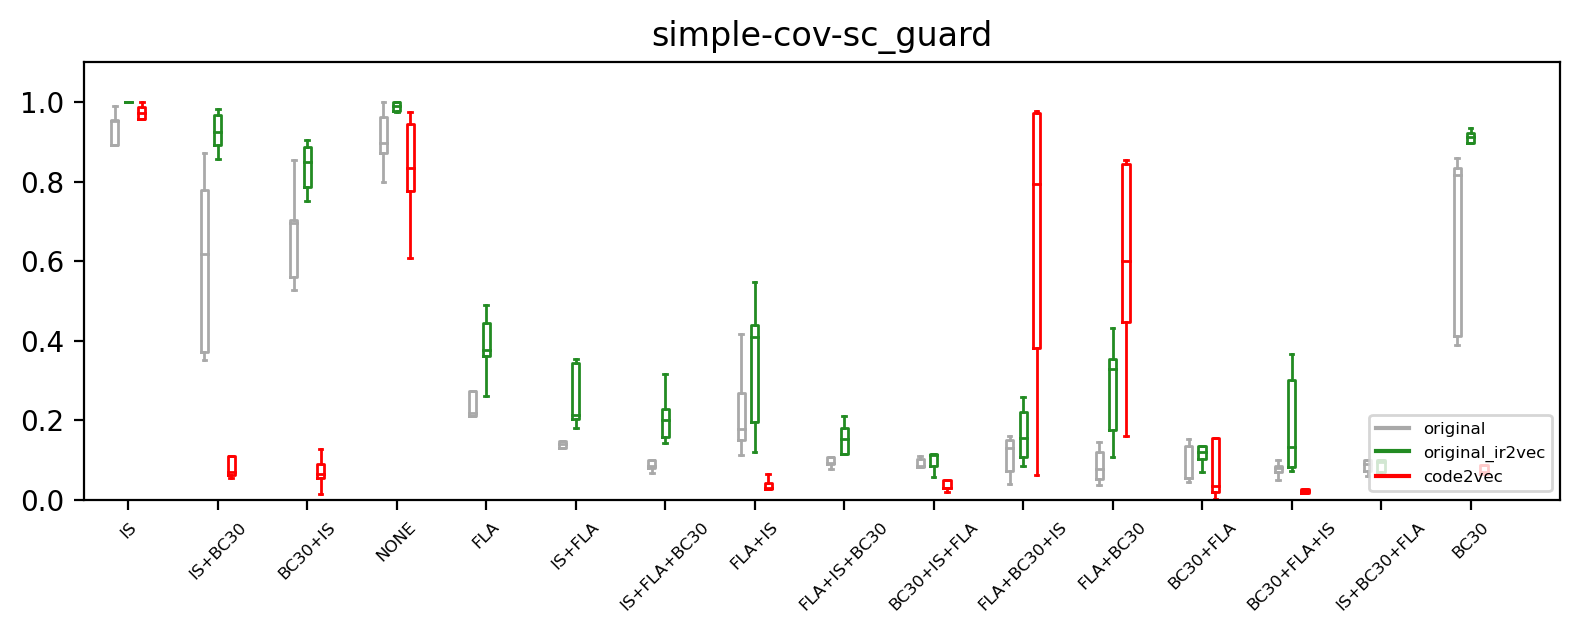

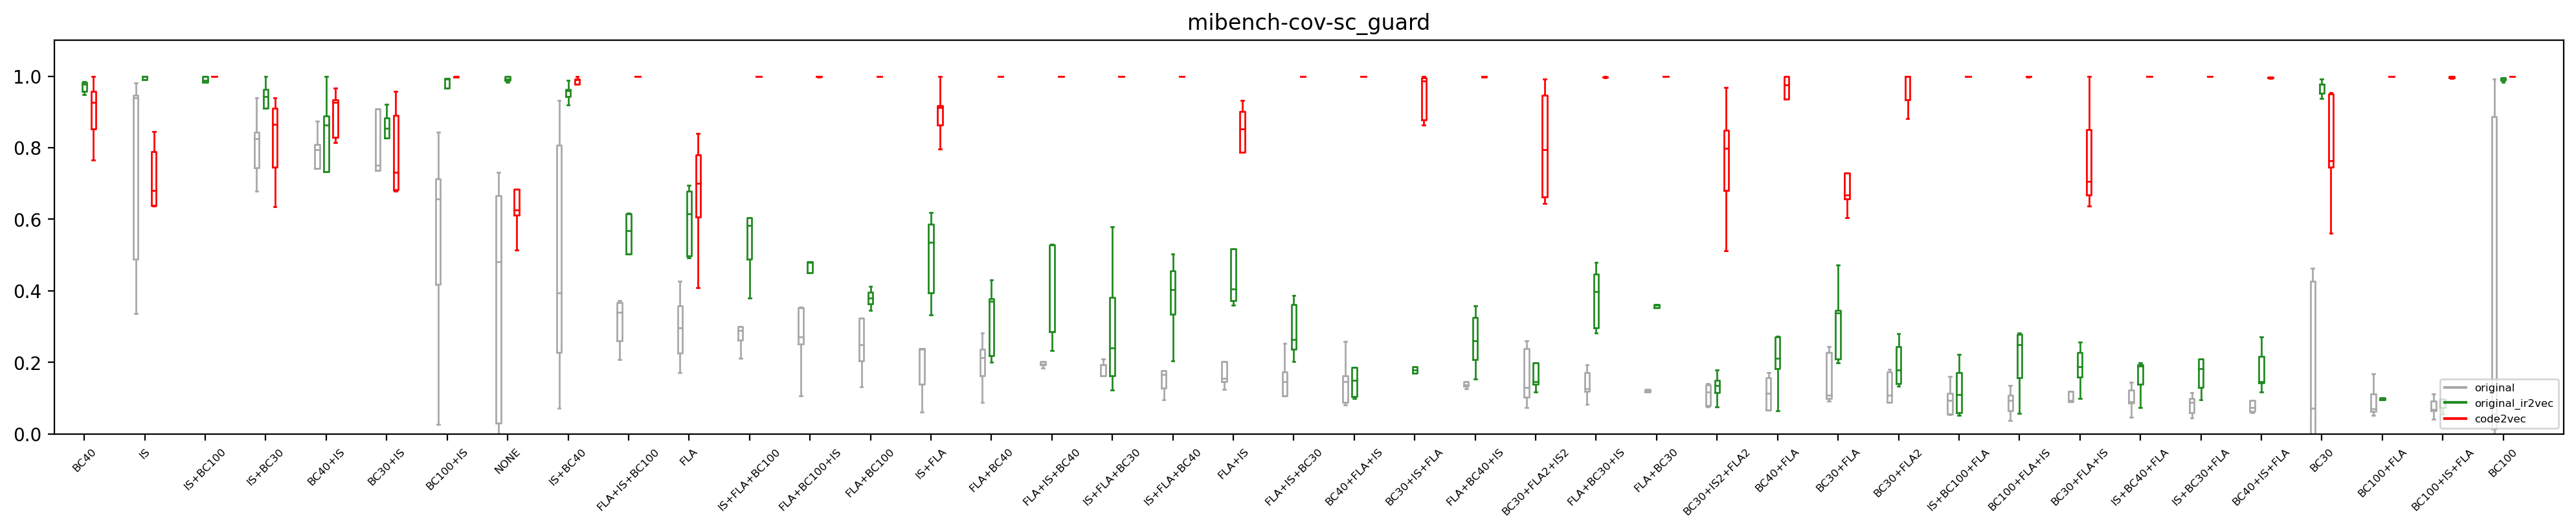

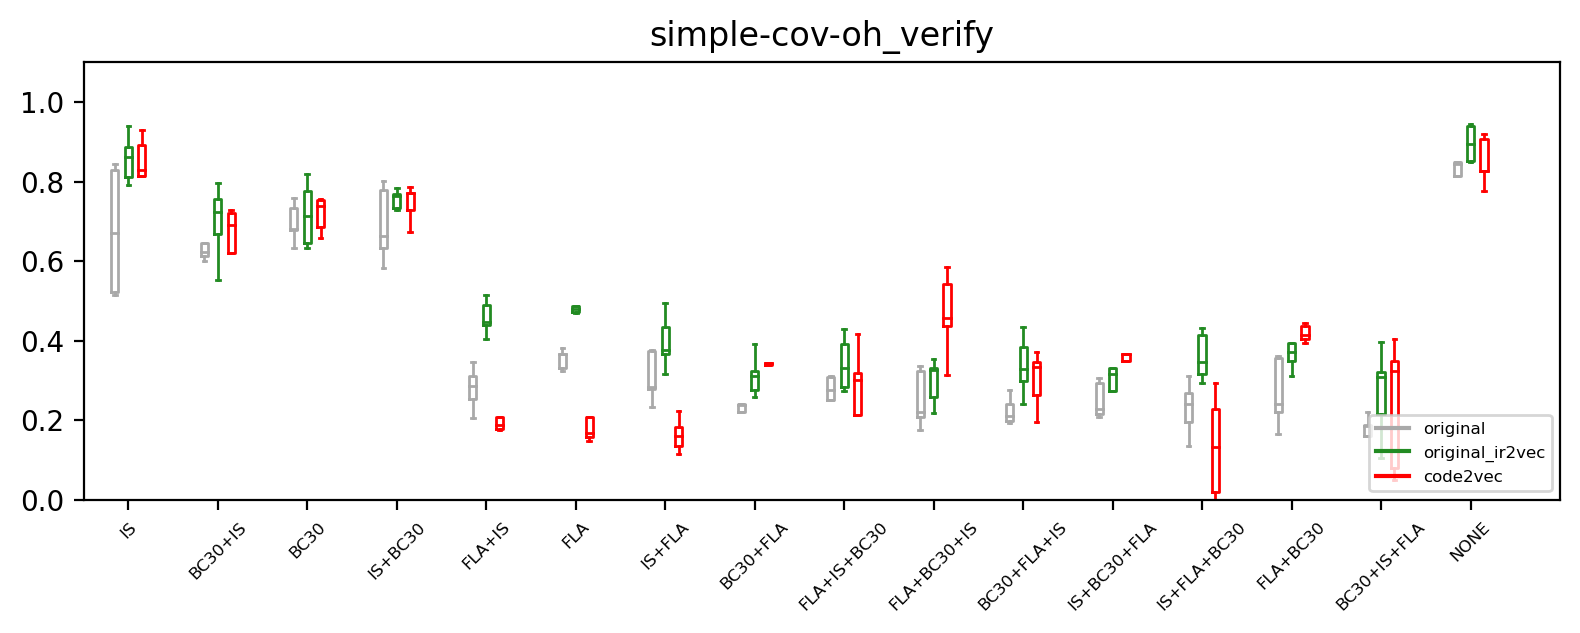

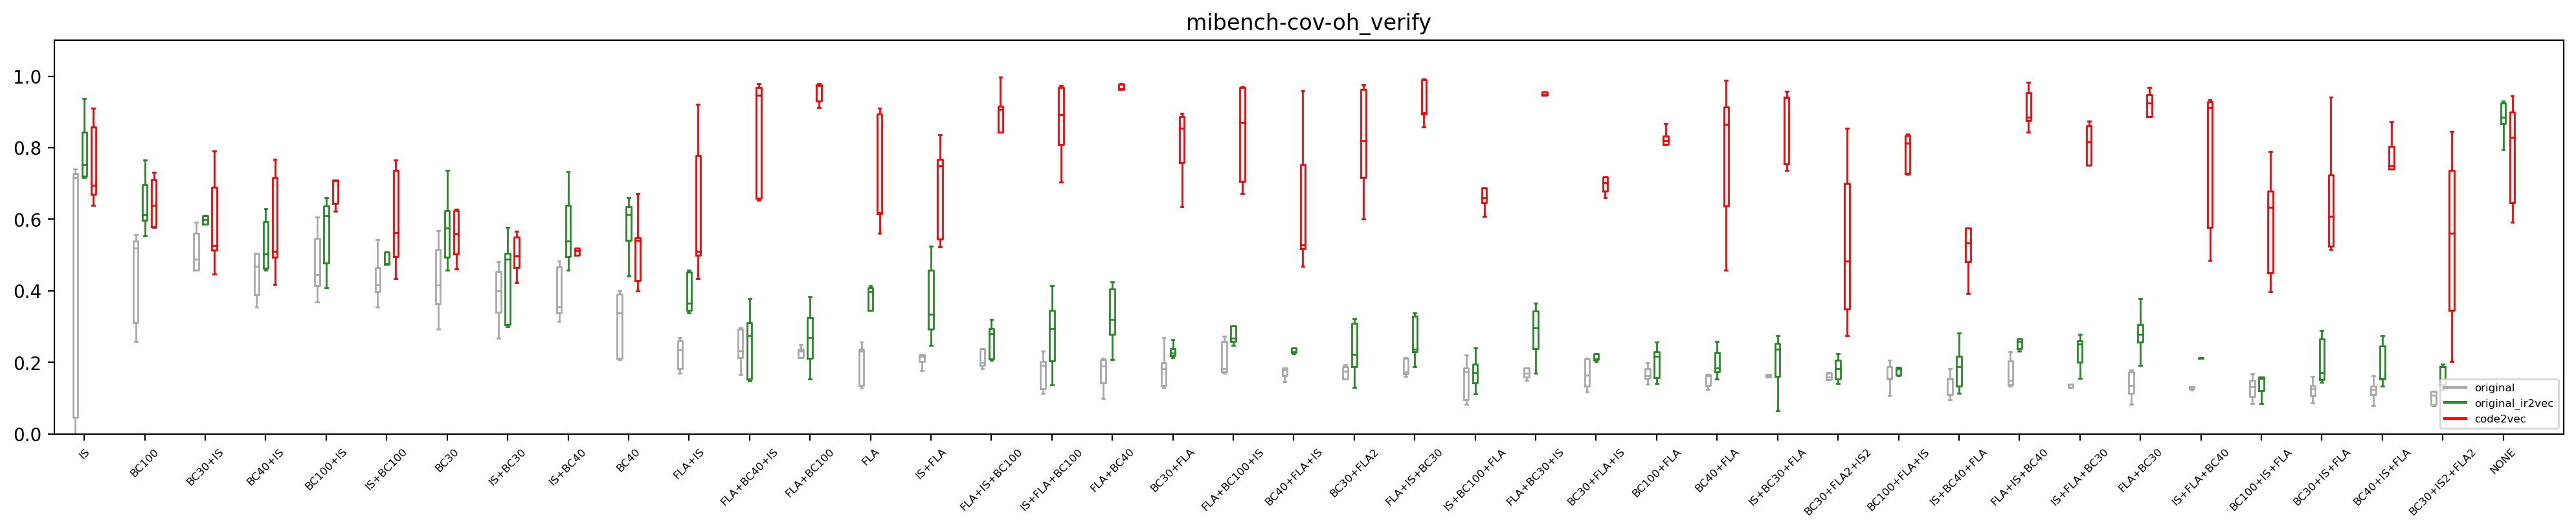

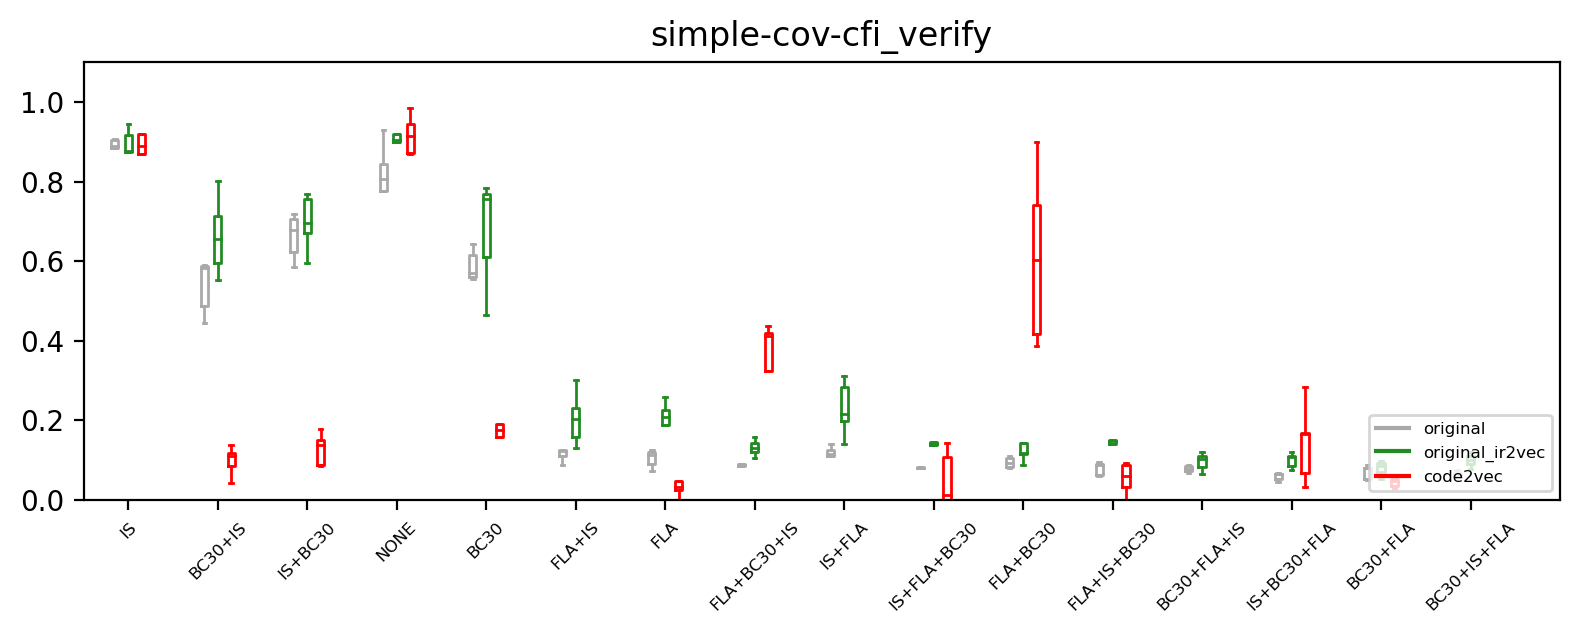

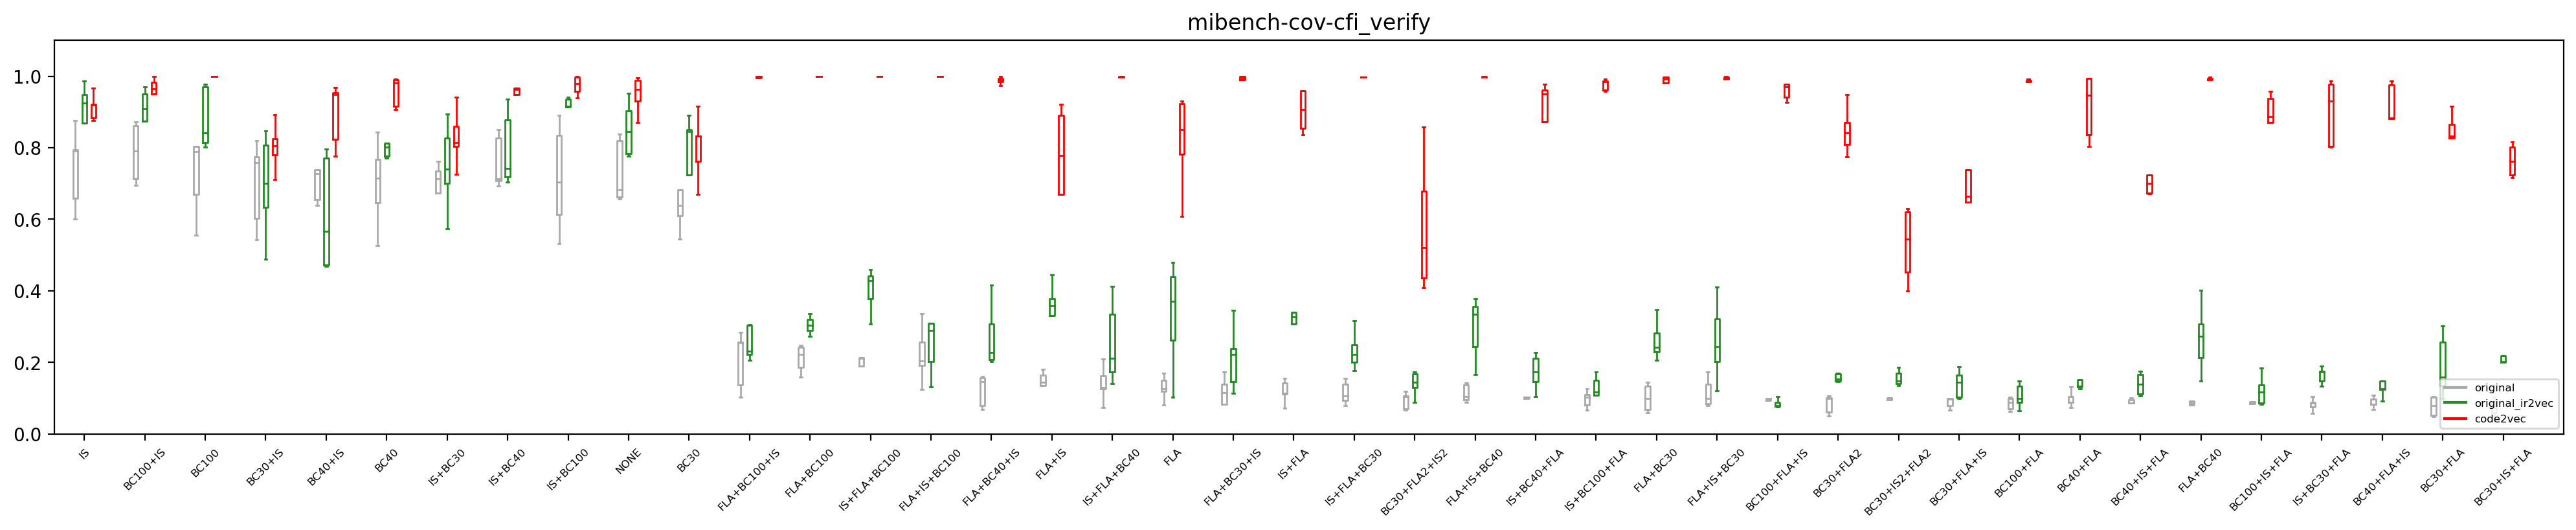

In [73]:
for protection in ['sc_guard', 'oh_verify', 'cfi_verify']:
    mibench_plot_results = get_plot_results(df, 'mibench-cov', protection)
    mibench_data_labels = sorted(
        mibench_plot_results.keys(), 
        key=lambda key: median(mibench_plot_results[key]['seg + tf_idf']),
        reverse=True
    )
    
    for src_dataset in ['simple-cov', 'mibench-cov']:
        plot_results = get_plot_results(df, src_dataset, protection)
        
        data_labels = sorted(plot_results.keys(), key=lambda key: mibench_data_labels.index(key) if key in mibench_data_labels else len(mibench_data_labels))

        data_values_original = [plot_results[label]['seg + tf_idf'] for label in data_labels]
        data_values_with_ir2vec = [plot_results[label]['seg + tf_idf + ir2vec'] for label in data_labels]
        data_values_code2vec = [plot_results[label]['code2vec'] for label in data_labels]

        plot_title = f'{src_dataset}-{protection}'
        file_name = f'plots/{plot_title}.pdf'
        plot_labels = ['original', 'original_ir2vec', 'code2vec']
        data_values = [data_values_original, data_values_with_ir2vec, data_values_code2vec]
        
        draw_plot(data_labels, data_values, plot_labels, plot_title, file_name)